In [1]:
from PandaSQLite import PandaSQLiteDB
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.colors as cl
from matplotlib import cm



In [2]:
db = PandaSQLiteDB("analysis.sql", auto_commit=False)

In [3]:
# for i in [512, 1024, 2048, 4096]:
#     db.import_data(f"{i}", f"{i}.csv")
db.import_data("strong", "strong.csv", if_exists="replace")
db.import_data("weak", "weak.csv", if_exists="replace")

In [4]:
db.get_table("strong")

n  procs         time       err
0    32768      1  1109.877828  0.005100
1    32768      2   557.145156  0.005153
2    32768      4   278.000880  0.004562
3    32768      4   277.825481  0.004810
4    32768      8   140.035928  0.004894
5    32768     16   106.832348  0.004004
6    32768     32    37.243901  0.004291
7    32768     64    37.574137  0.004900
8    32768    128    26.741387  0.005143
9    32768    256    19.999509  0.004827
10  300000    512   917.854899  0.004872

In [10]:
q = "CREATE TABLE data AS "
for i in [512, 1024, 2048, 4096]:
    q += f"SELECT * FROM \"{i}\" UNION "
q = q[:len(q) - len(" UNION ")]
print(q)
db.execute(q)

CREATE TABLE data AS SELECT * FROM "512" UNION SELECT * FROM "1024" UNION SELECT * FROM "2048" UNION SELECT * FROM "4096"


In [45]:
#db.execute("CREATE TABLE time as SELECT n_threads, size, time_pi*n_iter as time FROM data ORDER BY n_threads, size")
#db.execute(r"CREATE TABLE prefix AS SELECT DISTINCT size, '$' || size || ' \\times ' || size || '$' as prefix FROM data")
db.delete_table("prefix")
db.execute(r"CREATE TABLE prefix AS SELECT DISTINCT size, '$' || size || ' \times ' || size || '$' as prefix FROM data ORDER BY size")
# db.query(r"SELECT DISTINCT size, '$' || size || ' \\times ' || size || '$' as prefix FROM data")


n_threads  size          time
0          1   512  7.509101e+05
1          1  1024  3.005486e+06
2          1  2048  1.200194e+07
3          1  4096  4.799171e+07

In [39]:
db.query("SELECT * FROM speedup NATURAL JOIN prefix")

Threads  Size    Speedup               prefix
0         1   512   1.000000    $512 \\times 512$
1         1  1024   1.000000  $1024 \\times 1024$
2         1  2048   1.000000  $2048 \\times 2048$
3         1  4096   1.000000  $4096 \\times 4096$
4         2   512   1.955282    $512 \\times 512$
5         2  1024   1.982681  $1024 \\times 1024$
6         2  2048   2.006496  $2048 \\times 2048$
7         2  4096   2.010380  $4096 \\times 4096$
8         4   512   2.022107    $512 \\times 512$
9         4  1024   2.067080  $1024 \\times 1024$
10        4  2048   2.076899  $2048 \\times 2048$
11        4  4096   2.082533  $4096 \\times 4096$
12        8   512   3.000347    $512 \\times 512$
13        8  1024   3.047454  $1024 \\times 1024$
14        8  2048   3.099038  $2048 \\times 2048$
15        8  4096   3.108487  $4096 \\times 4096$
16       16   512   5.100590    $512 \\times 512$
17       16  1024   5.178541  $1024 \\times 1024$
18       16  2048   5.440406  $2048 \\times 2048$
19       16  4096   5.480148  $4096 \\times 4096$
20       32   512   8.452406    $512 \\times 512$
21       32  1024  10.007181  $1024 \\times 1024$
22       32  2048  10.276323  $2048 \\times 2048$
23       32  4096  10.531245  $4096 \\times 4096$
24       64   512   3.656789    $512 \\times 512$
25       64  1024  11.616179  $1024 \\times 1024$
26       64  2048  15.997736  $2048 \\times 2048$
27       64  4096  20.131156  $4096 \\times 4096$

In [7]:
q = "CREATE TABLE strong_speedup AS "
for index, row in db.query("SELECT * FROM strong WHERE threads = 1").iterrows():
    time = row['time']
    size = row['n']
    q += f"SELECT threads as Threads, n as Size, {time}/time as Speedup FROM strong WHERE size = {size} UNION "
q = q[:len(q) - len(" UNION ")]
print(q)

db.execute(q)

CREATE TABLE strong_speedup AS SELECT threads as Threads, n as Size, 91584.0/time as Speedup FROM strong WHERE size = 64.0 UNION SELECT threads as Threads, n as Size, 494719.0/time as Speedup FROM strong WHERE size = 128.0 UNION SELECT threads as Threads, n as Size, 3107100.0/time as Speedup FROM strong WHERE size = 256.0 UNION SELECT threads as Threads, n as Size, 24989500.0/time as Speedup FROM strong WHERE size = 512.0 UNION SELECT threads as Threads, n as Size, 211919000.0/time as Speedup FROM strong WHERE size = 1024.0


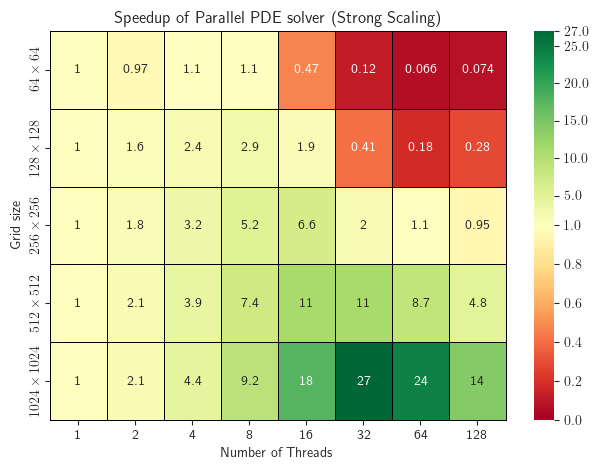

In [64]:
# Create the heatmap using Seaborn's heatmap function
plt.rcParams['text.usetex'] = True
df = db.get_table("strong_speedup")
heatmap_data = df.pivot(index='Size', columns='Threads', values='Speedup')
cmap = cm.RdYlGn
divnorm = TwoSlopeNorm(vmin=0, vcenter=1, vmax=27)
ax = sns.heatmap(heatmap_data, annot=True, linewidth=.5, linecolor='black', clip_on=False, cmap=cmap, norm=divnorm)


# Add custom labels to y-axis
yticklabels = [f"${i}\\times {i}$" for i in [64, 128, 256, 512, 1024]] # example custom labels
ax.set_yticklabels(yticklabels)

# Add labels and title
plt.xlabel('Number of Threads')
plt.ylabel('Grid size')
plt.title("Speedup of Parallel PDE solver (Strong Scaling)")

c_bar = ax.collections[0].colorbar
c_bar.set_ticks([1, 5, 10, 15, 20, 25, 27] + np.linspace(0, 0.8, 5).tolist())
plt.tight_layout()
plt.savefig(f"pde_strong_heatmap.pdf")



In [5]:
db.get_table("weak")

n  procs        time       err
0    8000      1   65.979148  0.003509
1   16000      4   66.427202  0.005024
2   32000     16   67.822495  0.005039
3   64000     64   95.250862  0.004157
4  128000    256  203.615665  0.005034

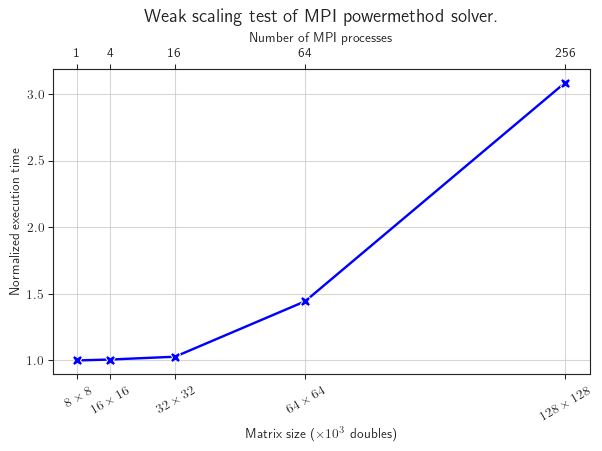

In [74]:

f, ax = plt.subplots(dpi=96)
plt.rcParams['text.usetex'] = True
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"

sns.lineplot(
    data=db.query("SELECT n/1000 as Size, time/65.979148 as Time, procs as Processes FROM weak"),
    x="Size",
    y="Time",
    linewidth=1.8,
    color="blue",
    # hue="Algorithm",
    # style="Algorithm",
    marker="X",
    markersize=8,
    #
    errorbar=None,
    ax=ax
).set_title("Weak scaling test of MPI powermethod solver.", pad=8, fontsize=14)

plt.grid(alpha=0.8)
#ax.set_xscale('log', base=2)
#sns.move_legend(ax, "upper left")
#plt.rcParams["font.serif"] = "Times New Roman"
ax.set(ylabel=r'Normalized execution time', xlabel=r'Matrix size ($\times 10^3$ doubles)')
#plt.xticks([128, 256, 512, 1024])
xn = db.query("SELECT n/1000 as n FROM weak")["n"]
ax.set_xticks(xn, [f"${i}\\times {i}$" for i in xn], rotation=30)
top_ax = ax.twiny()
top_ax.set_xlim(ax.get_xlim())
xp = db.query("SELECT procs FROM weak")["procs"]
top_ax.set_xticks(xn, xp)
top_ax.set(xlabel=r'Number of MPI processes')

ax.tick_params(axis='x', which='major', labelsize=10)
top_ax.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout()

plt.savefig(f"power_weak_scaling.pdf", format="pdf")


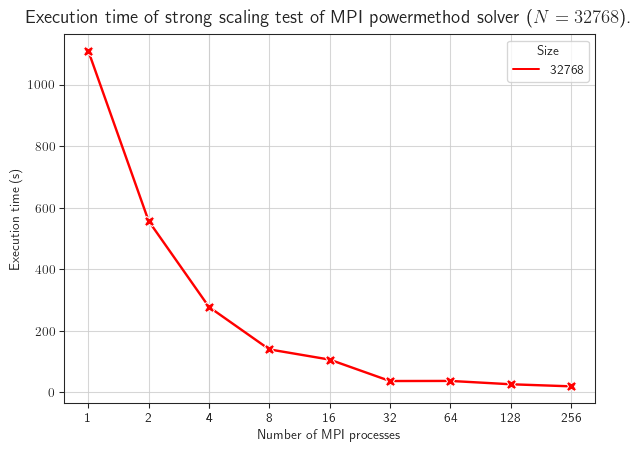

In [72]:
f, ax = plt.subplots(dpi=96)
plt.rcParams['text.usetex'] = True
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"

sns.lineplot(
    data=db.query("SELECT n as Size, time as Time, procs as Threads FROM strong WHERE procs < 260"),
    x="Threads",
    y="Time",
    linewidth=1.8,
    color="red",
    marker="X",
    hue="Size",
    palette=["red"],
    markersize=8,
    errorbar=None,
    ax=ax
).set_title("Execution time of strong scaling test of MPI powermethod solver ($N = 32768$).", pad=8, fontsize=14)

plt.grid(alpha=0.8)
ax.set_xscale('log', base=2)
#ax.set_yscale('log', base=10)
xp = db.query("SELECT procs FROM strong WHERE procs < 260")["procs"]
ax.set(ylabel=r'Execution time (s)', xlabel=r'Number of MPI processes')
ax.set_xticks(xp, [f"{i}" for i in xp])#, rotation="vertical")
ax.tick_params(axis='x', which='major', labelsize=10)

#yticks = np.power(10,np.linspace(-1.1, 2.5, 15))
#plt.yticks(yticks, ["{:.3f}".format(i) for i in yticks], rotation = 30)
plt.minorticks_off()
plt.tight_layout()

plt.savefig(f"power_strong_scaling_baseline.pdf", format="svg")

In [33]:
db.get_table("strong")

n  procs         time       err
0    32768      1  1109.877828  0.005100
1    32768      2   557.145156  0.005153
2    32768      4   278.000880  0.004562
3    32768      4   277.825481  0.004810
4    32768      8   140.035928  0.004894
5    32768     16   106.832348  0.004004
6    32768     32    37.243901  0.004291
7    32768     64    37.574137  0.004900
8    32768    128    26.741387  0.005143
9    32768    256    19.999509  0.004827
10  300000    512   917.854899  0.004872

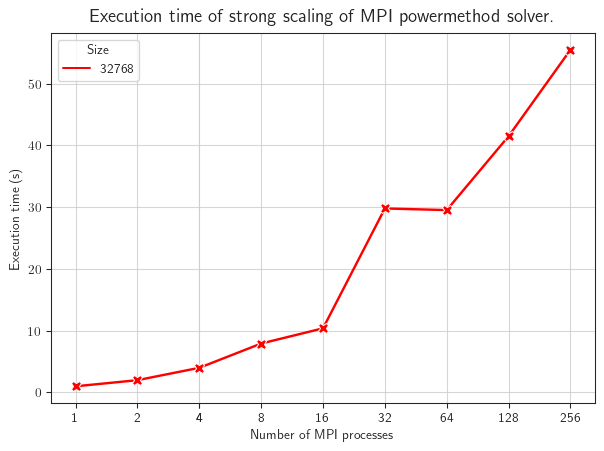

In [58]:
f, ax = plt.subplots(dpi=96)
plt.rcParams['text.usetex'] = True
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"

sns.lineplot(
    data=db.query("SELECT n as Size, 1109.877828/time as Time, procs as Threads FROM strong WHERE procs < 260"),
    x="Threads",
    y="Time",
    linewidth=1.8,
    hue="Size",
    marker="X",
    palette=["red"],
    markersize=8,
    errorbar=None,
    ax=ax
).set_title("Execution time of strong scaling test of MPI powermethod solver ($N = 32768$).", pad=8, fontsize=14)

plt.grid(alpha=0.8)
ax.set_xscale('log', base=2)
#ax.set_yscale('log', base=10)
ax.set(ylabel=r'Execution time (s)', xlabel=r'Number of MPI processes')
ax.set_xticks(xp, [f"{i}" for i in xp])#, rotation="vertical")
ax.tick_params(axis='x', which='major', labelsize=10)

#yticks = np.power(10,np.linspace(-1.1, 2.5, 15))
#plt.yticks(yticks, ["{:.3f}".format(i) for i in yticks], rotation = 30)
plt.minorticks_off()
plt.tight_layout()

plt.savefig(f"power_strong_scaling_baseline.pdf", format="svg")

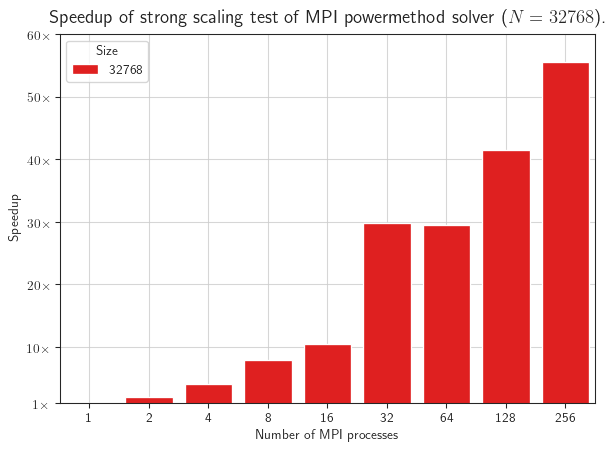

In [75]:
f, ax = plt.subplots(dpi=96)
plt.rcParams['text.usetex'] = True
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"

sns.barplot(
    data=db.query("SELECT n as Size, 1109.877828/time as Time, procs as Threads FROM strong WHERE procs < 260"),
    x="Threads",
    y="Time",
    #linewidth=1.8,
    hue="Size",
    #color="red",
    #marker="X",
    palette=["red"],
    #markersize=8,
    #errorbar=None,
    ax=ax
).set_title("Speedup of strong scaling test of MPI powermethod solver ($N = 32768$).", pad=8, fontsize=14)

plt.grid(alpha=0.8)
#ax.set_xscale('log', base=2)
#ax.set_yscale('log', base=10)
ax.set(ylabel=r'Speedup', xlabel=r'Number of MPI processes')
#ax.set_xticks(xp, [f"{i}" for i in xp])#, rotation="vertical")
ax.tick_params(axis='x', which='major', labelsize=10)
plt.ylim((1, 60))

yticks = [1] + list(range(10, 70, 10))
plt.yticks(yticks, [f"${i} \\times$" for i in yticks])
plt.minorticks_off()
plt.tight_layout()

plt.savefig(f"power_strong_scaling_speedup.pdf", format="svg")

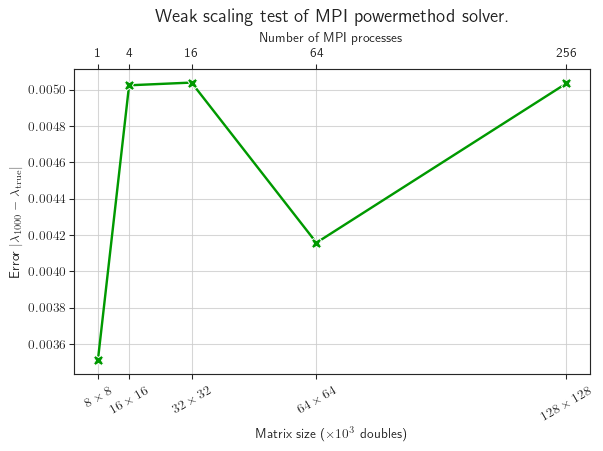

In [12]:
f, ax = plt.subplots(dpi=96)
plt.rcParams['text.usetex'] = True
sns.set_style("ticks")
pal = sns.color_palette("bright")
colors = pal.as_hex()
colors[5] = "#57b3e9"

sns.lineplot(
    data=db.query("SELECT n/1000 as Size, err as Error, procs as Processes FROM weak"),
    x="Size",
    y="Error",
    linewidth=1.8,
    color="#009900",
    # hue="Algorithm",
    # style="Algorithm",
    marker="X",
    markersize=8,
    #
    errorbar=None,
    ax=ax
).set_title("Weak scaling test of MPI powermethod solver.", pad=8, fontsize=14)

plt.grid(alpha=0.8)
#ax.set_xscale('log', base=2)
#sns.move_legend(ax, "upper left")
#plt.rcParams["font.serif"] = "Times New Roman"
ax.set(ylabel=r'Error $|\lambda_{1000} - \lambda_{\mathrm{true}}|$', xlabel=r'Matrix size ($\times 10^3$ doubles)')
#plt.xticks([128, 256, 512, 1024])
xn = db.query("SELECT n/1000 as n FROM weak")["n"]
ax.set_xticks(xn, [f"${i}\\times {i}$" for i in xn], rotation=30)
top_ax = ax.twiny()
top_ax.set_xlim(ax.get_xlim())
xp = db.query("SELECT procs FROM weak")["procs"]
top_ax.set_xticks(xn, xp)
top_ax.set(xlabel=r'Number of MPI processes')

ax.tick_params(axis='x', which='major', labelsize=10)
top_ax.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout()

plt.savefig(f"power_err.pdf", format="pdf")

In [75]:
db.get_table("weak")

n_threads       size      time
0          1   10000000   11779.4
1          2   20000000   18311.8
2          4   40000000   19198.4
3          8   80000000   22016.8
4         16  160000000   29199.6
5         32  320000000   50009.7
6         64  640000000  103586.0